# Results from WandB


## Imports

In [2]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns

## Load Results

In [7]:
sweep_path = 'gbena/funcspec/xartyp2h'
sweep_id = sweep_path.split('/')[-1]
total_data = pd.read_pickle(f'../../results/sweep_tables/{sweep_id}')
total_data.columns, total_data.shape

(Index(['Step', 'best_acc', 'n_hidden', 'sparsity', 'mean_corr_global_diff',
        'bottleneck_global_diff', 'name'],
       dtype='object'),
 (760, 7))

## Plot Smooth Heatmap

In [8]:
filtered_data = total_data[(total_data['Step'] == 1)]
filtered_data.shape

(380, 7)

In [9]:
y_values, x_values, z_values = filtered_data[['sparsity', 'n_hidden', 'bottleneck_global_diff']].values.T

In [27]:
ratio = (y_values/x_values).mean()
smoothness = 1.5
resolution = 300

sigmas = np.array([1, ratio])*smoothness

def gaussian_filter(x, y, sigmas=sigmas) : 
    
    return np.exp(-(x**2/sigmas[0]**2 + y**2/sigmas[1]**2))
    
def weighted_average(x, y, sigmas=sigmas) : 

    return (z_values * gaussian_filter(x - x_values, y - y_values, sigmas)).sum() / gaussian_filter(x - x_values, y - y_values, sigmas).sum()

vect_avg = np.vectorize(weighted_average, signature=('(),()->()'))

def plot_filter(sigmas) :
    Y = np.linspace(1e-5, 1, 200)
    X = np.linspace(5, 50, 200)

    point = (10, .5)

    filter = lambda x, y : gaussian_filter( (x - point[0]), y - point[1], sigmas=sigmas).mean()
    Z = np.array([[filter(x, y) for x in X] for y in Y])
    sns.heatmap(Z)

In [28]:
Y = np.linspace(y_values.min(), y_values.max(), resolution) #500 x 500 takes 10s
X = np.linspace(x_values.min(), x_values.max(), resolution)
Xm, Ym = np.meshgrid(X, Y)
Z = vect_avg(Xm, Ym)

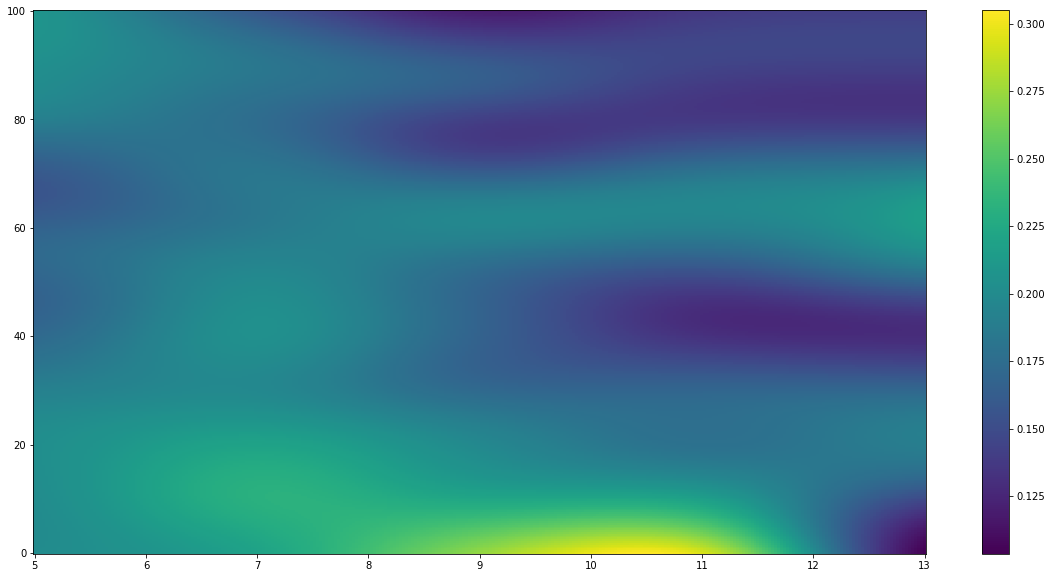

In [29]:
plt.figure(figsize=(20, 10))
plt.pcolormesh(X, Y, Z, cmap='viridis')
#plt.yscale('log')
#plt.grid(True)
plt.colorbar()

In [48]:
np.logspace(-3, 0, 10)

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

In [50]:
np.linspace(10, 30, 11)

array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30.])

In [44]:
1/20**2

0.0025

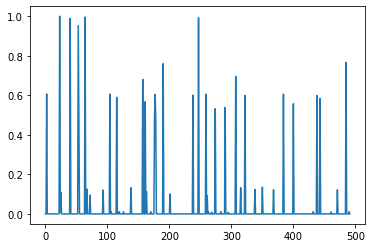

In [186]:
plt.plot(filter(5, 0.1))